In [1]:
# -*- coding: utf-8 -*-
import os
import sys
import csv
import time
import json
import datetime
import pickle as pkl
import tensorflow as tf
from tensorflow.contrib import learn
import collections
from collections import Counter
import data_helper
#import data_helper
#from rnn_classifier import rnn_clf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import pandas as pd
%matplotlib inline

/home/anastasia/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# Parameters
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
FLAGS = AttrDict()

In [3]:
# Model parameters
FLAGS['clf'] =  'gru' # Type of classifier
# Data parameters
FLAGS['data_file'] = 'data/ev_thread.csv'
FLAGS['emb_file'] = "./glove.6B/glove.6B.100d.txt"

FLAGS['test_size'] =  0.1 # 'Validation test size'

# Model hyperparameters

FLAGS['hidden_size'] =  100 #'Number of hidden units 
FLAGS['embedding_size'] = 100
FLAGS['num_layers'] =  1 # 'Number of the GRU cells
FLAGS['keep_prob'] =  1 # 'Dropout keep probability'  
FLAGS['learning_rate'] =  3e-4 # 'Learning rate' 
FLAGS['l2_reg_lambda'] =  0 # 'L2 regularization lambda

# Training parameters
FLAGS['batch_size'] = 100 # 'Batch size'
FLAGS['num_epochs'] = 40 # 'Number of epochs'
FLAGS['evaluate_every_steps'] = 10 # 'Evaluate the model on validation set after this many steps'

FLAGS['random_state'] = 13

In [4]:
# Load data and transform to embeddings
data_is_loaded = True

if data_is_loaded == False:
    data = pd.read_json("./data/dataset.json", lines=True)
    data_cleaned = data_helper.clean_data(data, 2, 200) #saves changed data to ev_thread.csv
    ids, data, labels, lengths, vocab_embs = data_helper.data_to_emb(data_file_path=FLAGS.data_file,
                                                               emb_file_path=FLAGS.emb_file)
    np.savez("data/data_to_train.npz", ids=ids, data=data, labels=labels, lengths=lengths, vocab_embs=vocab_embs)
else:
    data_dict = np.load("data/data_to_train.npz")
    ids = data_dict['ids']
    data = data_dict['data']
    labels = data_dict['labels']
    lengths = data_dict['lengths']
    vocab_embs = data_dict['vocab_embs']
FLAGS.vocab_size = vocab_embs.shape[1]

In [5]:
#GRU or BiGRU classifier
class rnn_clf(object):
    """"
    LSTM  for text classification
    """
    def __init__(self, config):
        #self.num_classes = config.num_classes
        self.vocab_size = config.vocab_size
        self.hidden_size = config.hidden_size
        self.num_layers = config.num_layers
        self.l2_reg_lambda = config.l2_reg_lambda

        # Placeholders
        self.batch_size = tf.placeholder(dtype=tf.int32, shape=[])
        self.input_x = tf.placeholder(dtype=tf.int32, shape=[None, None])
        self.input_y = tf.placeholder(dtype=tf.float32, shape=[None])
        self.keep_prob = tf.placeholder(dtype=tf.float32, shape=[])
        self.sequence_length = tf.placeholder(dtype=tf.int32, shape=[None])

        # L2 loss
        self.l2_loss = tf.constant(0.0)

        # Word embedding
        self.embedding = tf.placeholder(shape=[self.vocab_size, self.hidden_size], dtype=tf.float32)
        inputs = tf.nn.embedding_lookup(self.embedding, self.input_x)

        # Input dropout
        self.inputs = tf.nn.dropout(inputs, keep_prob=self.keep_prob)

        #GRU
        if config.clf == 'gru':
            self.final_state = self.bi_gru()
    

        # Softmax output layer
        with tf.name_scope('softmax'):
            # softmax_w = tf.get_variable('softmax_w', shape=[self.hidden_size, self.num_classes], dtype=tf.float32)
            if config.clf == 'gru':
                output_w = tf.get_variable('output_w', shape=[2 * self.hidden_size, 1], dtype=tf.float32)
            
            output_b = tf.get_variable('ouput_b', shape=[1], dtype=tf.float32)

            # L2 regularization for output layer
            self.l2_loss += tf.nn.l2_loss(output_w)
            self.l2_loss += tf.nn.l2_loss(output_b)

            if config.clf == 'gru':
                self.output = tf.matmul(self.final_state, output_w) + output_b

            self.predictions = tf.reshape(self.output, [-1])

        # Loss
        with tf.name_scope('loss'):
            tvars = tf.trainable_variables()

            # L2 regularization for LSTM weights
            for tv in tvars:
                if 'kernel' in tv.name:
                    self.l2_loss += tf.nn.l2_loss(tv)

            losses = tf.losses.mean_squared_error(labels=self.input_y, predictions=self.predictions)
            self.cost = tf.reduce_mean(losses) + self.l2_reg_lambda * self.l2_loss

        # Accuracy
        with tf.name_scope('accuracy'):
            correct_predictions = tf.equal(tf.round(self.predictions), tf.round(self.input_y))
            self.correct_num = tf.reduce_sum(tf.cast(correct_predictions, tf.float32))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')
            #self.accuracy = tf.contrib.metrics.streaming_accuracy(tf.to_float(self.predictions), tf.to_float(self.input_y))
        with tf.name_scope('pearson'):
            #self.pearson = tf.contrib.metrics.streaming_pearson_correlation(tf.to_float(self.predictions), tf.to_float(self.input_y))
            self.pearson, self.cov, self.var_y_pred, self.var_y_true = self.pearson_f()
            
    def pearson_f(self):
        y_pred = tf.to_float(self.predictions)
        y_true = tf.to_float(self.input_y)
        mean_y_pred, var_y_pred = tf.nn.moments(y_pred, axes=0)
        mean_y_true, var_y_true = tf.nn.moments(y_true, axes=0)
        cov = tf.nn.moments(tf.multiply(y_pred, y_true), axes = 0)[0] - mean_y_pred * mean_y_true
        var_mult = tf.multiply(var_y_pred, var_y_true)
        pearson_corr = tf.divide(cov, tf.sqrt(var_mult))
        return pearson_corr, cov, var_y_pred, var_y_true
        
    def normal_lstm(self):
        # LSTM Cell
        #print("embedding", sess.run(self.embedding))
        cell = tf.contrib.rnn.LSTMCell(self.hidden_size,
                                       forget_bias=1.0,
                                       state_is_tuple=True,
                                       reuse=tf.get_variable_scope().reuse)
        # Add dropout to cell output
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=self.keep_prob)
        # Stacked LSTMs
        cell = tf.contrib.rnn.MultiRNNCell([cell] * self.num_layers, state_is_tuple=True)

        self._initial_state = cell.zero_state(self.batch_size, dtype=tf.float32)

        # Dynamic LSTM
        with tf.variable_scope('GRU'):
            outputs, state = tf.nn.dynamic_rnn(cell,
                                               inputs=self.inputs,
                                               initial_state=self._initial_state,
                                               sequence_length=self.sequence_length)

        final_state = state
        return final_state
        
    def normal_gru(self):
        # GRU Cell
        #print("embedding", sess.run(self.embedding))
        cell = tf.contrib.rnn.GRUCell(self.hidden_size,
                                       reuse=tf.get_variable_scope().reuse)
        # Add dropout to cell output
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=self.keep_prob)
        # Stacked LSTMs
        cell = tf.contrib.rnn.MultiRNNCell([cell] * self.num_layers, state_is_tuple=True)

        self._initial_state = cell.zero_state(self.batch_size, dtype=tf.float32)

        # Dynamic LSTM
        with tf.variable_scope('GRU'):
            outputs, state = tf.nn.dynamic_rnn(cell,
                                               inputs=self.inputs,
                                               initial_state=self._initial_state,
                                               sequence_length=self.sequence_length)

        final_state = state

        return final_state
    
    def bi_gru(self):
        cell_fw = tf.contrib.rnn.GRUCell(self.hidden_size,
                                       reuse=tf.get_variable_scope().reuse)

        cell_bw = tf.contrib.rnn.GRUCell(self.hidden_size,
                                       reuse=tf.get_variable_scope().reuse)


        # Add dropout to cell output
        cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, output_keep_prob=self.keep_prob)
        cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, output_keep_prob=self.keep_prob)

        # Stacked GRUs
        cell_fw = tf.contrib.rnn.MultiRNNCell([cell_fw] * self.num_layers, state_is_tuple=True)
        cell_bw = tf.contrib.rnn.MultiRNNCell([cell_bw] * self.num_layers, state_is_tuple=True)

        self._initial_state_fw = cell_fw.zero_state(self.batch_size, dtype=tf.float32)
        self._initial_state_bw = cell_bw.zero_state(self.batch_size, dtype=tf.float32)

        # Dynamic GRU
        with tf.variable_scope('Bi-LSTM'):
            _, state = tf.nn.bidirectional_dynamic_rnn(cell_fw,
                                                       cell_bw,
                                                       inputs=self.inputs,
                                                       initial_state_fw=self._initial_state_fw,
                                                       initial_state_bw=self._initial_state_bw,
                                                       sequence_length=self.sequence_length)

        state_fw = state[0]
        state_bw = state[1]
        output = tf.concat([state_fw[self.num_layers - 1], state_bw[self.num_layers - 1]], 1)

        return output

In [6]:
FLAGS.vocab_size = vocab_embs.shape[1]

FLAGS.max_length = max(lengths)


# Train-validation split
x_train, x_valid, y_train, y_valid, train_lengths, valid_lengths = data_helper.my_train_test_split(ids, data,
                                                                                    labels,
                                                                                    lengths,
                                                                                    test_size=FLAGS.test_size,
                                                                                    random_state=FLAGS.random_state)
train_data = data_helper.batch_iter(x_train, y_train, train_lengths, FLAGS.batch_size, FLAGS.num_epochs)


In [7]:
# Train
# =============================================================================
train_costs = []
valid_costs = []
train_pearson = []
valid_pearson = []
valid_spearman = []
with tf.Graph().as_default():
    with tf.Session() as sess:
        if FLAGS.clf == 'gru':
            classifier = rnn_clf(FLAGS)

        # Train procedure
        global_step = tf.Variable(0, name='global_step', trainable=False)
        optimizer = tf.train.AdamOptimizer(FLAGS.learning_rate)
        grads_and_vars = optimizer.compute_gradients(classifier.cost)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

       

        sess.run(tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()))


        def run_step(input_data, is_training=True, print_predictions=False):
            """Run one step of the training process."""
            input_x, input_y, sequence_length = input_data
            fetches = {'step': global_step,
                       'cost': classifier.cost,
                       'accuracy': classifier.accuracy, 
                       'pearson': classifier.pearson,
                       'cov': classifier.cov,
                       'var_y_true': classifier.var_y_true,
                       'var_y_pred': classifier.var_y_pred}
            feed_dict = {classifier.input_x: input_x,
                         classifier.input_y: input_y}
            
            fetches['predictions'] = classifier.predictions

           
            fetches['final_state'] = classifier.final_state
            feed_dict[classifier.batch_size] = len(input_x)
            feed_dict[classifier.sequence_length] = sequence_length

            if is_training:
                fetches['train_op'] = train_op
               
                feed_dict[classifier.keep_prob] = FLAGS.keep_prob
                
            else:
               
                feed_dict[classifier.keep_prob] = 1.0
            feed_dict[classifier.embedding] = np.transpose(vocab_embs)

            vars = sess.run(fetches, feed_dict)
            step = vars['step']
            cost = vars['cost']
            accuracy = vars['accuracy']
            
            pearson = vars['pearson']
            predictions = vars['predictions']

            if is_training:
                pass
            else:

                time_str = datetime.datetime.now().isoformat()
                #print("{}: step: {}, loss: {:g}, accuracy: {:g}, pearson: {:g}".format(time_str, step, cost, accuracy, pearson))
                
            if print_predictions:
                pass
                #print('Predictions:')
                #print(predictions)
                #print('Labels:')
                #print(input_y)
            return cost, predictions


        print('Start training ...')

        for train_input in train_data:
            cost, predictions = run_step(train_input, is_training=True)
            current_step = tf.train.global_step(sess, global_step)

            if current_step % FLAGS.evaluate_every_steps == 0:
                #print('\nTraining')
                cost, predictions = run_step(train_input, is_training=False)
                train_costs.append(cost)
                #print('\nValidation')
                cost, predictions = run_step((x_valid, y_valid, valid_lengths), is_training=False)
                valid_costs.append(cost)
                y_valid = y_valid.astype(np.float)
                valid_pearson.append(pearsonr(predictions, y_valid)[0])
                valid_spearman.append(spearmanr(predictions, y_valid)[0])
                #print('')

           

        run_step((x_valid, y_valid, valid_lengths), is_training=False, print_predictions=True)
print("The End")

Start training ...


Min loss =  1.8844099
Max pearson =  0.19606778265917682
Max spearman =  0.18425013151198935


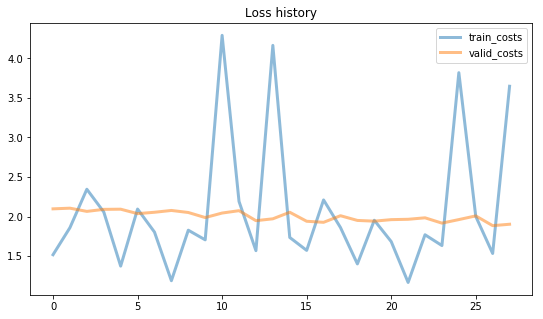

In [8]:
#Prints min loss, max pearson, max spearman
#Loss graph
print("Min loss = ", min(valid_costs))
print("Max pearson = ", max(valid_pearson))
print("Max spearman = ", max(valid_spearman))
plt.figure(figsize=(9, 5))
plt.plot(train_costs, label='train_costs', alpha=0.5, lw=3)
plt.plot(valid_costs, label='valid_costs', alpha=0.5, lw=3)

plt.title("Loss history")
plt.legend()
plt.show()

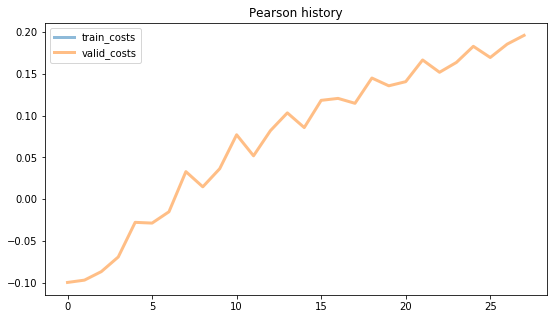

In [9]:
# Pearson graph
plt.figure(figsize=(9, 5))
plt.plot(train_pearson, label='train_costs', alpha=0.5, lw=3)
plt.plot(valid_pearson, label='valid_costs', alpha=0.5, lw=3)

plt.title("Pearson history")
plt.legend()
plt.show()